# Double pendulum using Lagrange's equation

Defines a LagrangianPendulum class that is used to generate basic pendulum plots from solving Lagrange's equations.

* Last revised 04-Apr-2020 by Federico Gremmo (gremmo.1@osu.edu).

## Euler-Lagrange equation

For a simple pendulum, the Lagrangian with generalized coordinate $\phi$ is

$\begin{align}
  \mathcal{L} = \frac12 m L^2 \dot\phi^2 - mgL(1 - \cos\phi)
\end{align}$

The Euler-Lagrange equation is

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi} = \frac{\partial\mathcal L}{\partial\phi}
 \quad\Longrightarrow\quad
 m L^2 \ddot \phi = -mgL\sin\phi
  \ \mbox{or}\ \ddot\phi = - \omega_0^2\sin\phi = 0
  \;.
\end{align}$

## Hamilton's equations

The generalized momentum corresponding to $\phi$ is

$\begin{align}
   \frac{\partial\mathcal{L}}{\partial \dot\phi} = m L^2 \dot\phi \equiv p_\phi
   \;.
\end{align}$

We can invert this equation to find $\dot\phi = p_\phi / m L^2$.
Constructing the Hamiltonian by Legendre transformation we find 

$\begin{align}
  \mathcal{H} &= \dot\phi p_\phi  - \mathcal{L} \\
              &= \frac{p_\phi^2}{m L^2} - \frac12 m L^2 \dot\phi^2 + mgL(1 - \cos\phi) \\
              &= \frac{p_\phi^2}{2 m L^2} + mgL(1 - \cos\phi)
              \;.
\end{align}$

Thus $\mathcal{H}$ is simply $T + V$.  Hamilton's equations are

$\begin{align}
  \dot\phi &= \frac{\partial\mathcal{H}}{\partial p_\phi} = \frac{p_\phi}{m L^2} \\
  \dot p_\phi &= -\frac{\partial\mathcal{H}}{\partial \phi} = -mgL \sin\phi 
  \;.
\end{align}$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

from matplotlib import animation, rc
import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 12
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [4]:
class LagrangianPendulum():
    """
    Pendulum class implements the parameters and Lagrange's equations for 
     a simple pendulum (no driving or damping).
     
    Parameters
    ----------
    L1, L1 : float
        length of the first and second pendulums
    g : float
        gravitational acceleration at the earth's surface
    m1, m2 : float
        mass of pendulums

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1 = 1., L2 = 1., m1 = 1., m2 = 1., g = 1. #Defines the attributes of the class LagrangianPendulum.
                ):
        self.L1 = L1
        self.g = g
        self.m1 = m1
        self.L2 = L2
        self.m2 = m2
           
    def dy_dt(self, t, y): #This function returns the angles tetha1 and tetha2 as a functon 
                           #of time, as defined in the solution of the EOM's.
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 2-component vector with y[0] = phi(t) and y[1] = dphi/dt
            
        Returns
        -------        
        """     
        phi_1, phi_dot_1, phi_2, phi_dot_2 = y
        return [y[1],\
                (-self.g*(2*self.m1+self.m2)*np.sin(phi_1)-self.m2*g*np.sin(phi_1-phi_2)-2*np.sin(phi_1-phi_2)*self.m2*(phi_dot_2**2*self.L2+phi_dot_1**2*self.L1*np.cos(phi_1-phi_2)))/(self.L1*(2*self.m1+self.m2-self.m2*np.cos(2*phi_1-2*phi_2))),\
                y[3],\
                (2*np.sin(phi_1-phi_2)*(phi_dot_1**2*self.L1*(self.m1+self.m2)+self.g*(self.m1+self.m2)*np.cos(phi_1)+phi_dot_2**2*self.L2*self.m2*np.cos(phi_1-phi_2)))/(self.L2*(2*self.m1+self.m2-self.m2*np.cos(2*phi_1-2*phi_2)))]
    
   
    def solve_ode(self, t_pts, phi_1_0, phi_dot_1_0, phi_2_0, phi_dot_2_0, #Solves the ODE.
                  abserr=1.0e-9, relerr=1.0e-9):                           #I do not understand the syntax
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi_1_0, phi_dot_1_0, phi_2_0, phi_dot_2_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi_1, phi_dot_1, phi_2, phi_dot_2 = solution.y

        return phi_1, phi_dot_1, phi_2, phi_dot_2
    
    def evolve(self):
        theta1 = self.theta1
        theta2 = self.theta2
        p1 = self.p1
        p2 = self.p2
        g = self.g
        l = self.length
        self.solve_ode()
 
        new_position = self.polar_to_cartesian()
        self.trajectory.append(new_position)
        return new_position

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make simple pendulum plots 

In [7]:
# Labels for individual plot axes
phi_1_vs_time_labels = (r'$t$', r'$\phi_{{1}}(t)$')
phi_2_vs_time_labels = (r'$t$', r'$\phi_{{2}}(t)$')
phi_a_vs_phi_b_labels = (r'$\phi_{{2}}(t)$', r'$\phi_{{1}}(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L = 1.
g = 1.
mass = 1.

# Instantiate a pendulum 
p1 = LagrangianPendulum(L1=1., L2 = 1., m1=1., m2=1., g=1.)


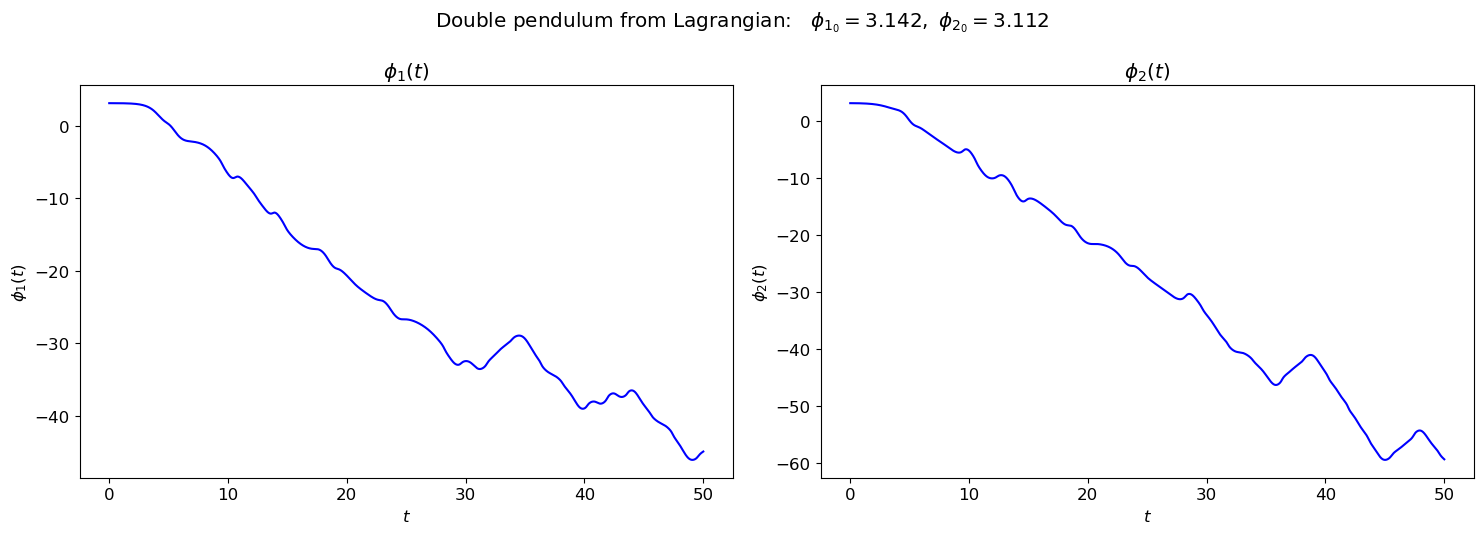

In [8]:
# both plots: same initial conditions
phi_1_0 = np.pi
phi_2_0 = np.pi - 0.03
phi_dot_1_0 = 0
phi_dot_2_0 = 0

phi_1, phi_dot_1, phi_2, phi_dot_2 = p1.solve_ode(t_pts, phi_1_0, phi_dot_1_0, phi_2_0, phi_dot_2_0)

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $\phi_{{1_0}} = {phi_1_0:.3f},$' + \
                rf' $\phi_{{2_0}} = {phi_2_0:.3f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi_1 plot 
ax_a = fig.add_subplot(1,2,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi_1[start : stop], 
            axis_labels=phi_1_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\phi_{{1}}(t)$', 
            ax=ax_a)    
                              
# second plot: phi_2 plot 
ax_b = fig.add_subplot(1,2,2)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi_2[start : stop], 
            axis_labels=phi_2_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\phi_{{2}}(t)$', 
            ax=ax_b)    

fig.tight_layout()
fig.savefig('simple_pendulum_Lagrange.png', bbox_inches='tight')  

Now trying the power spectrum, plotting only positive frequencies and cutting off the lower peaks:

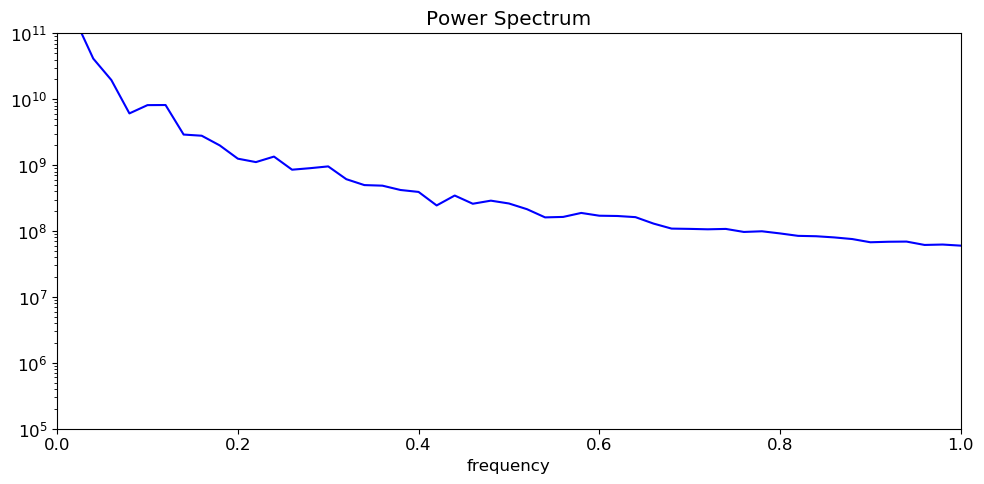

In [9]:
start, stop = start_stop_indices(t_pts, t_start, t_end)    
signal = phi_1[start:stop]
power_spectrum = np.abs(np.fft.fft(signal))**2
freqs = np.fft.fftfreq(signal.size, delta_t)
idx = np.argsort(freqs)

fig_ps = plt.figure(figsize=(10,5))
ax_ps = fig_ps.add_subplot(1,1,1)
ax_ps.semilogy(freqs[idx], power_spectrum[idx], color='blue')
ax_ps.set_xlim(0, 1.)
ax_ps.set_ylim(1.e5, 1.e11)
ax_ps.set_xlabel('frequency')
ax_ps.set_title('Power Spectrum')

fig_ps.tight_layout()

# Animated Lagrangian Double Pendulum

Now in order to visualize the movement of the pendulum from the calculates ODEs I have built an animator and updated the definition of the pendulum to don't receive parameters of time, so it can be used by FuncAnimate from Matplotlib to interate and calculate the ODE every time.

In [10]:
import matplotlib
%matplotlib qt5
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt 
import scipy as sp
import matplotlib.animation as animation

In [11]:
class AnimatedLagrangianPendulum:
    
    def __init__(self, theta1, theta2, dt):
        self.theta1 = theta1
        self.theta2 = theta2
        self.p1 = 0.0
        self.p2 = 0.0
        self.dt = dt
        self.g = 9.81
        self.length = 1.0
         
        self.trajectory = [self.polar_to_cartesian()]
 
    def polar_to_cartesian(self):
        x1 =  self.length * sp.sin(self.theta1)        
        y1 = -self.length * sp.cos(self.theta1)
         
        x2 = x1 + self.length * sp.sin(self.theta2)
        y2 = y1 - self.length * sp.cos(self.theta2)
         
        return sp.array([[0.0, 0.0], [x1, y1], [x2, y2]])
    
    def evolve(self):
        theta1 = self.theta1
        theta2 = self.theta2
        p1 = self.p1
        p2 = self.p2
        g = self.g
        l = self.length
 
        expr1 = sp.cos(theta1 - theta2)
        expr2 = sp.sin(theta1 - theta2)
        expr3 = (1 + expr2**2)
        expr4 = p1 * p2 * expr2 / expr3
        expr5 = (p1**2 + 2 * p2**2 - p1 * p2 * expr1) * sp.sin(2 * (theta1 - theta2)) / 2 / expr3**2
        expr6 = expr4 - expr5
 
        self.theta1 += self.dt * (p1 - p2 * expr1) / expr3
        self.theta2 += self.dt * (2 * p2 - p1 * expr1) / expr3
        self.p1 += self.dt * (-2 * g * l * sp.sin(theta1) - expr6)
        self.p2 += self.dt * (-g * l * sp.sin(theta2) + expr6)
 
        new_position = self.polar_to_cartesian()
        self.trajectory.append(new_position)
        return new_position

In [12]:
class PendulumAnimator:
    """
        pendulum: defined pendulum in the exercise with its trajectory
        draw_trace: trace or not a line to follow the second pendulum movement
    """
    def __init__(self, pendulum, draw_trace=False):
        self.pendulum = pendulum
        self.draw_trace = draw_trace
        self.time = 0.0
 
        # set up the figure
        self.fig, self.ax = plt.subplots()
        self.ax.set_ylim(-2.5, 2.5)
        self.ax.set_xlim(-2.5, 2.5)
 
        # prepare a text window for the timer
        self.time_text = self.ax.text(0.05, 0.95, '', 
            horizontalalignment='left', 
            verticalalignment='top', 
            transform=self.ax.transAxes)
 
        # initialize by plotting the last position of the trajectory
        self.line, = self.ax.plot(
            self.pendulum.trajectory[-1][:, 0], 
            self.pendulum.trajectory[-1][:, 1], 
            marker='o')
         
        # trace the whole trajectory of the second pendulum mass
        if self.draw_trace:
            self.trace, = self.ax.plot(
                [a[2, 0] for a in self.pendulum.trajectory],
                [a[2, 1] for a in self.pendulum.trajectory])
            
    def advance_time_step(self):
        while True:
            self.time += self.pendulum.dt
            yield self.pendulum.evolve()
            
    def update(self, data):
        self.time_text.set_text('Elapsed time: {:6.2f} s'.format(self.time))
     
        self.line.set_ydata(data[:, 1])
        self.line.set_xdata(data[:, 0])
         
        if self.draw_trace:
            self.trace.set_xdata([a[2, 0] for a in self.pendulum.trajectory])
            self.trace.set_ydata([a[2, 1] for a in self.pendulum.trajectory])
        return self.line,
    
    def animate(self):
        self.animation = animation.FuncAnimation(self.fig, self.update,
                         self.advance_time_step, interval=25, blit=False)

In [13]:
pendulum1 = AnimatedLagrangianPendulum(theta1=sp.pi, theta2=sp.pi-0.003, dt=0.01)
animator1 = PendulumAnimator(pendulum=pendulum1, draw_trace=False)
animator1.animate()

pendulum2 = AnimatedLagrangianPendulum(theta1=sp.pi, theta2=sp.pi-0.25, dt=0.01)
animator2 = PendulumAnimator(pendulum=pendulum2, draw_trace=False)
animator2.animate()

plt.show()